In [2]:
# standard python utilities
import os
from os.path import join, basename,dirname, exists
import sys
import glob
import pandas as pd
import numpy as np
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator


In [3]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

fig_dir = proj_dir+'/Streambed_seepage/figures/'
hob_dir = join(gwfm_dir, 'HOB_data')
sfr_dir = gwfm_dir+'/SFR_data/'




In [1]:

def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)


In [4]:

add_path(doc_dir+'/GitHub/flopy')
import flopy 

In [5]:
py_dir = join(doc_dir,'GitHub/CosumnesRiverRecharge/python_utilities')

add_path(py_dir)

from mf_utility import get_layer_from_elev
from map_cln import gdf_bnds, plt_cln

In [8]:
# scenario = '' # baseline, levee removal occurred in 2014
# create identifier for scenario if levee removal didn't occur
scenario = 'no_reconnection'

In [9]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

model_nam = 'inset_oneto_denier'
# model_nam = 'oneto_denier_homogeneous'
# upscale='upscale8x_'
upscale = 'upscale4x_'
model_nam = 'oneto_denier_'+upscale+'2014_2018'

model_ws = join(loadpth,model_nam)
if scenario != '':
    model_ws += '_' + scenario
    
# model_ws = join(loadpth,'parallel_oneto_denier','realization000')
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt',
                              load_only=load_only,
                              )



In [57]:
model_ws0 = join(loadpth,model_nam)

In [10]:
print('Quantiles: ',[0,0.5,0.6,0.75,1])
print('HK :',np.quantile(m.upw.hk.array,[0,0.5,0.6,0.75,1]))
print('VKA :',np.quantile(m.upw.vka.array,[0,0.5,0.6,0.75,1]))

Quantiles:  [0, 0.5, 0.6, 0.75, 1]
HK : [  0.56160003   5.82119989  21.60000038  65.08080292 345.6000061 ]
VKA : [  0.56160003   0.74236608   1.11835396  21.60000038 345.6000061 ]


In [11]:
model_grp = 'inset_oneto_denier'
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_grp,'rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs=grid_p.crs)

In [18]:
XSg = pd.read_csv(join(model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [19]:
sfr = m.sfr
sfrdf = pd.DataFrame(sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
# use facies of vka just below stream
vka_sfr = m.upw.vka.array[sfrdf.k, sfrdf.i, sfrdf.j]
vka_quants = pd.DataFrame(np.quantile(vka_sfr, tprogs_quants))
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[vka_sfr > vka_quants.iloc[n].values[0],'facies'] = vka_quants.index[n+1]
if 'Logger Location' in XSg.columns:
    drop_iseg = XSg[~XSg['Logger Location'].isna()].iseg.values
    # remove stream segments for routing purposes only
    grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]

In [20]:
params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv', index_col='Zone')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400 
vka = m.upw.vka.array
tprogs_vals = np.arange(1,5)
tprogs_hist = np.flip([0.590, 0.155, 0.197, 0.058])
tprogs_quants = 1-np.append([0], np.cumsum(tprogs_hist)/np.sum(tprogs_hist))
vka_quants = pd.DataFrame(tprogs_quants[1:], columns=['quant'], index=tprogs_vals)
# dataframe summarizing dominant facies based on quantiles
vka_quants['vka_min'] = np.quantile(vka, tprogs_quants[1:])
vka_quants['vka_max'] = np.quantile(vka, tprogs_quants[:-1])
vka_quants['facies'] = params.loc[tprogs_vals].Lithology.values

In [21]:
sfrdf = pd.DataFrame(sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)
# group sfrdf by vka quantiles
sfr_vka = vka[grid_sfr.k, grid_sfr.i, grid_sfr.j]
for p in vka_quants.index:
    facies = vka_quants.loc[p]
    grid_sfr.loc[(sfr_vka< facies.vka_max)&(sfr_vka>= facies.vka_min),'facies'] = facies.facies
#     # add color for facies plots
# grid_sfr = grid_sfr.join(gel_color.set_index('geology')[['color']], on='facies')

In [22]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')


## Sensor data and XS data

In [23]:
rm_grid = pd.read_csv(join(proj_dir, 'mw_hob_cleaned.csv'))
rm_grid = gpd.GeoDataFrame(rm_grid, geometry = gpd.points_from_xy(rm_grid.Longitude,rm_grid.Latitude), 
                           crs='epsg:4326').to_crs(grid_p.crs)
# get model layer for heads
hob_row = rm_grid.row.values-1
hob_col = rm_grid.column.values-1

In [24]:
gwl_long = pd.read_csv(join(model_ws,'gwl_long.csv'), parse_dates=['dt'])

In [25]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')


In [26]:

# correspond XS to sensors
rm_elev = gpd.sjoin_nearest(XSg, rm_grid, how='right',lsuffix='xs', rsuffix='rm')
#MW_11, MW_CP1 had doubles with sjoin_nearest due to XS duplicates from Oneto_Denier
rm_elev = rm_elev.drop_duplicates(['xs_num','Sensor'])

## Model output - time variant

In [27]:
strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = (strt_date + pd.Series((m.dis.nper-1)*15).astype('timedelta64[m]'))[0] # SS
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
hrs_from_strt = ((np.append([0], np.repeat(stplen, m.dis.nstp.array)[:-1])).cumsum()*24).astype('timedelta64[h]')
dates_stps = strt_date + hrs_from_strt


In [28]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper
# dt_ref

In [34]:
# load summary water budget
wb = pd.read_csv(model_ws+'/flow_budget.txt', delimiter=r'\s+')
# wb = pd.read_csv(loadpth+'/oneto_denier_upscale8x_2014_2018'+'/flow_budget.txt', delimiter=r'\s+')

wb['kstpkper'] = list(zip(wb.STP-1,wb.PER-1))
wb = wb.merge(dt_ref, on='kstpkper')


In [35]:
wb_cols = wb.columns[wb.columns.str.contains('_IN|_OUT')]
wb_cols = wb_cols[~wb_cols.str.contains('STORAGE')]
wb_out_cols= wb_cols[wb_cols.str.contains('_OUT')]
wb_in_cols = wb_cols[wb_cols.str.contains('_IN')]
# only include columns with values used
wb_out_cols = wb_out_cols[np.sum(wb[wb_out_cols]>0, axis=0).astype(bool)]
wb_in_cols = wb_in_cols[np.sum(wb[wb_in_cols]>0, axis=0).astype(bool)]


<Axes: xlabel='dt'>

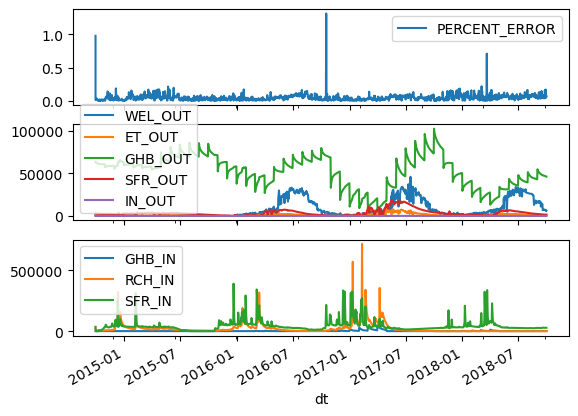

In [37]:
fig,ax= plt.subplots(3,1, sharex=True)
wb.plot(x='dt',y='PERCENT_ERROR', ax=ax[0])
wb.plot(x='dt',y=wb_out_cols, ax=ax[1], legend=True)
wb.plot(x='dt',y=wb_in_cols, ax=ax[2], legend=True)


In [38]:

def clean_hob(model_ws):
    hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,names = ['sim_val','obs_val','obs_nam'],
                         dtype = {'sim_val':float,'obs_val':float,'obs_nam':object})
    hobout[['Sensor', 'spd']] = hobout.obs_nam.str.split('p',n=2, expand=True)
    hobout['kstpkper'] = list(zip(np.full(len(hobout),0), hobout.spd.astype(int)))
    hobout = hobout.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    hobout.loc[hobout.sim_val.isin([-1e30, -999.99]), 'sim_val'] = np.nan
    hobout = hobout.dropna(subset='sim_val')
    hobout['error'] = hobout.obs_val - hobout.sim_val
    hobout['sq_error'] = hobout.error**2
    
    return(hobout)


In [39]:
hobout = clean_hob(model_ws)
# removing oneto ag because of large depth offset
hobout = hobout[hobout.Sensor != 'MW_OA']

In [60]:
hobout0 = clean_hob(model_ws0)
# removing oneto ag because of large depth offset
hobout0 = hobout0[hobout0.Sensor != 'MW_OA']

In [71]:
hob_long = hobout.join(hobout0.set_index('obs_nam')[['sim_val']], on='obs_nam',rsuffix='0')
hob_long = hob_long.melt(id_vars=['dt', 'Sensor'],value_vars=['sim_val','obs_val','sim_val0'],
                         value_name='gwe', var_name='type')

# hob_long = hobout.melt(id_vars=['dt', 'Sensor'],value_vars=['sim_val','obs_val'], value_name='gwe', var_name='type')


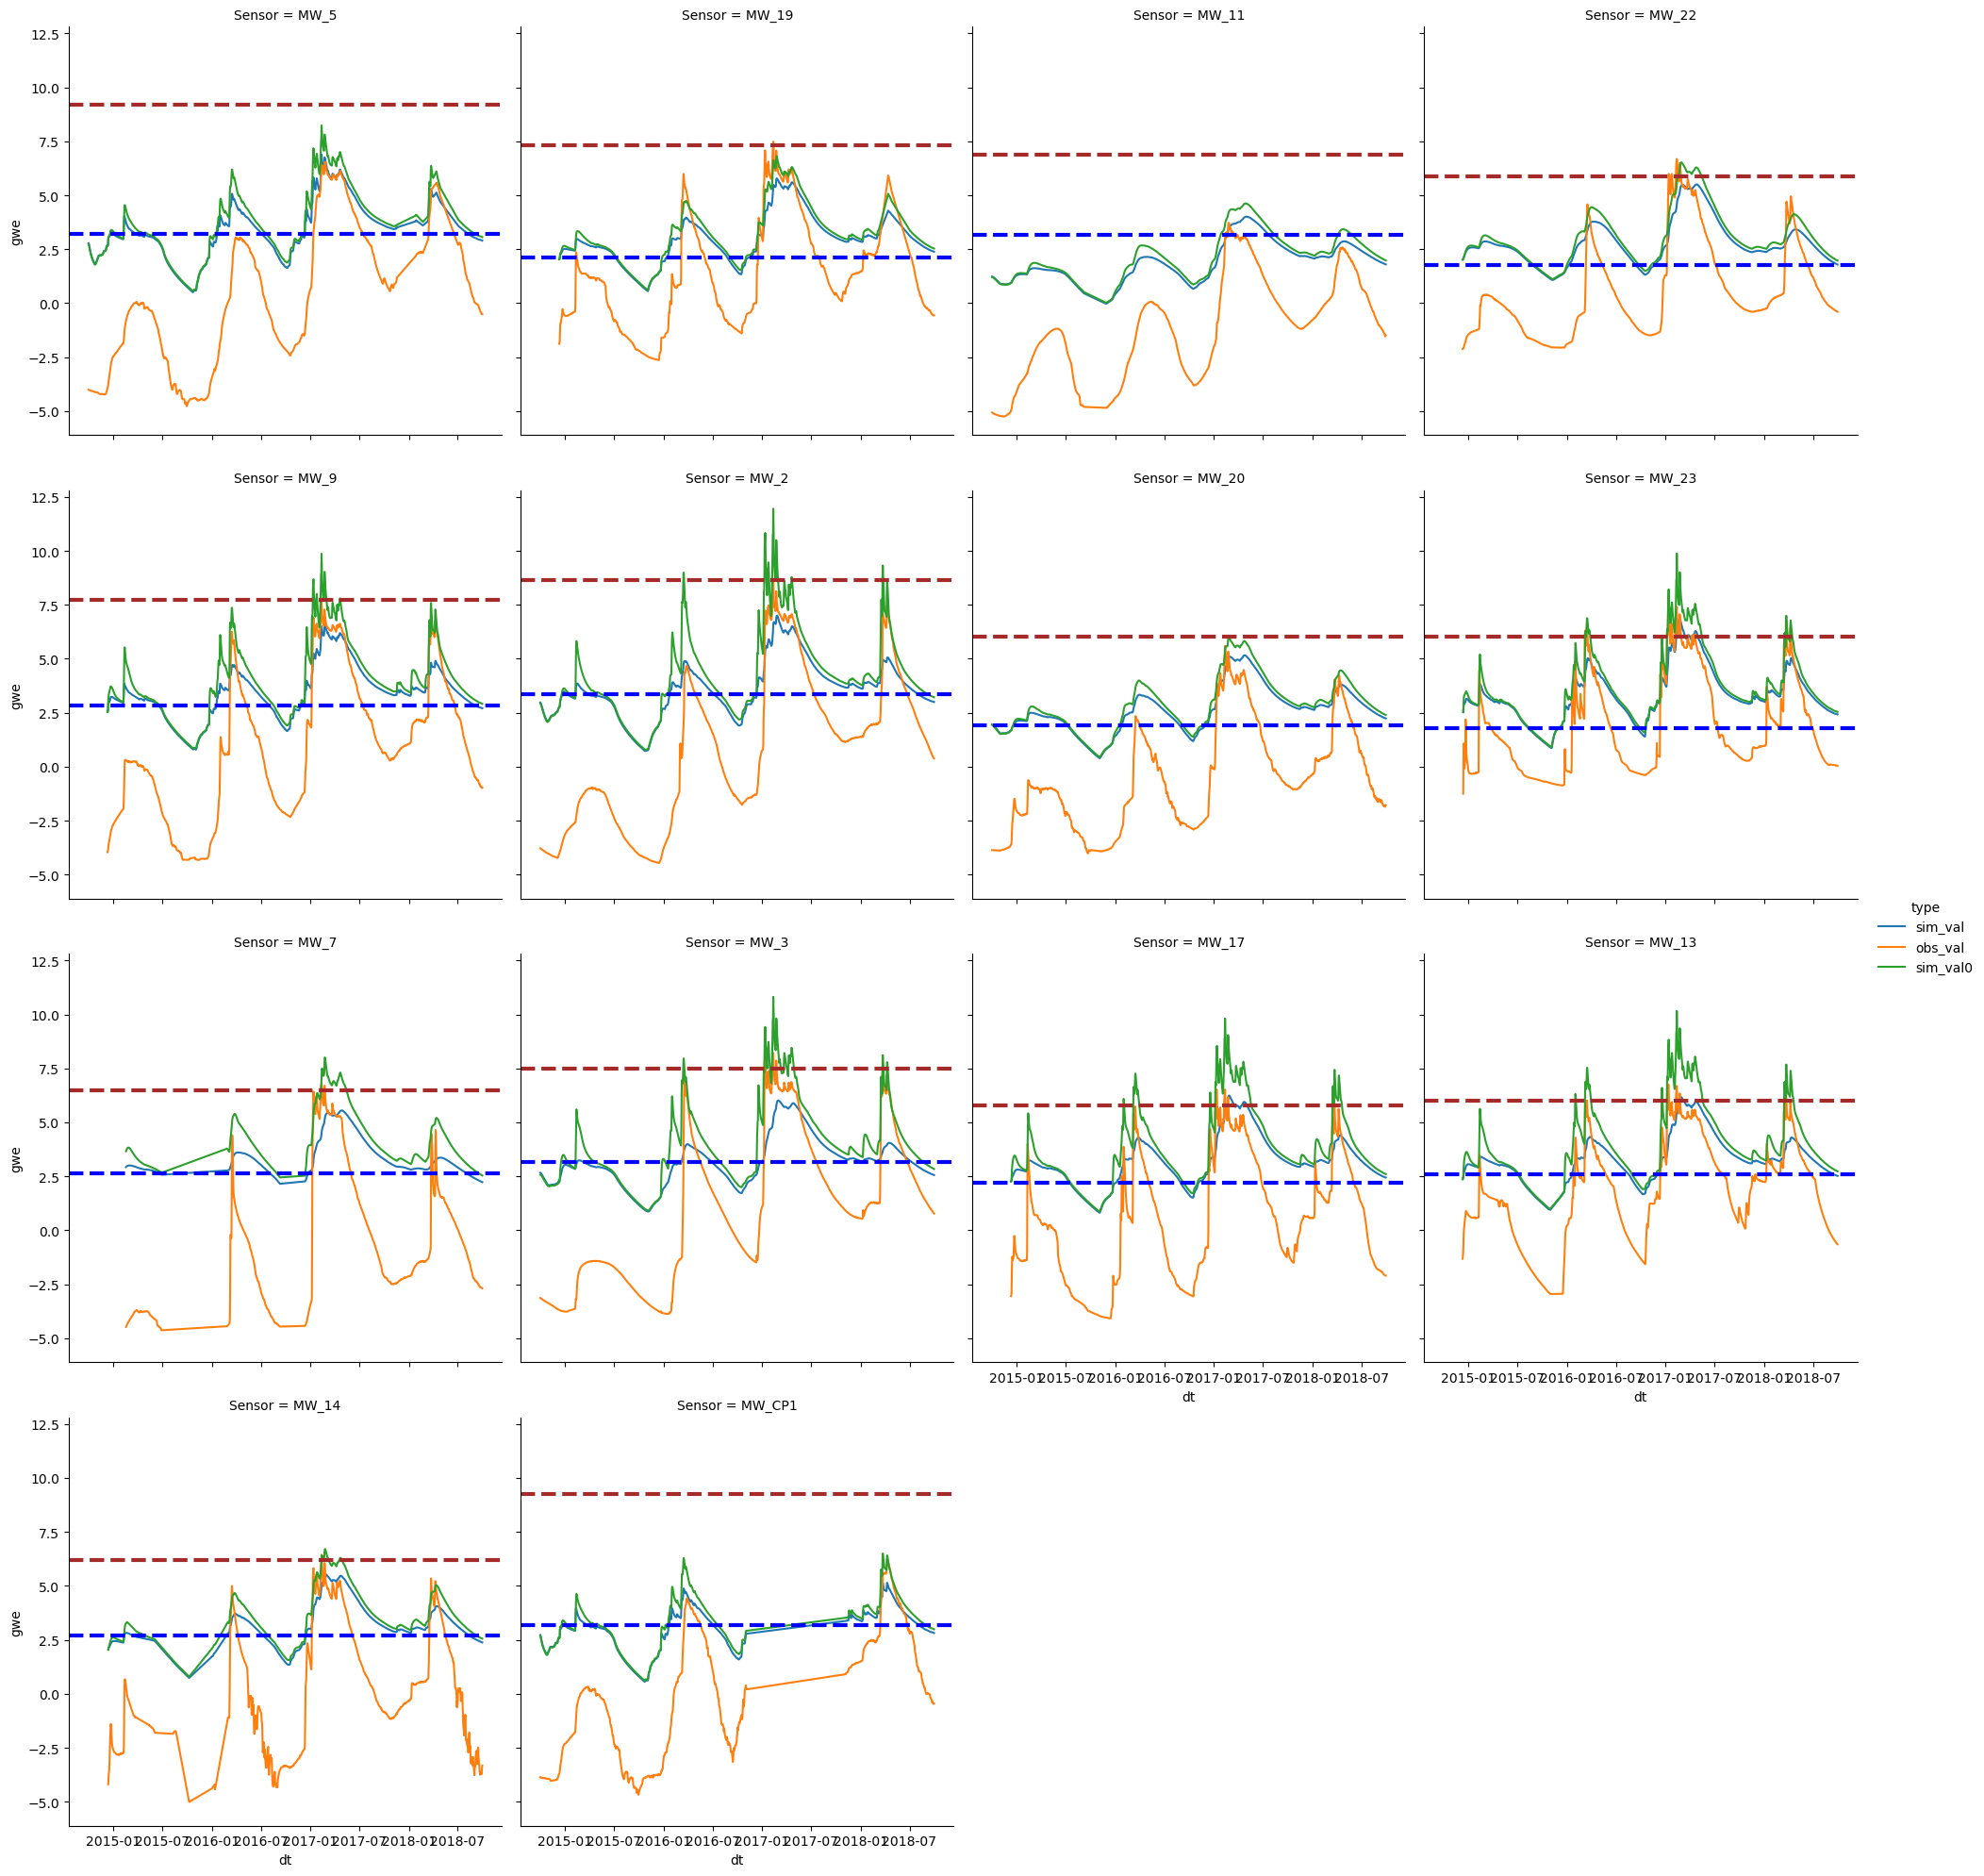

In [72]:
# hob_long, x='dt',y='
g = sns.relplot(hob_long, x='dt',y='gwe',col='Sensor',hue = 'type',  col_wrap=4, kind='line')

axes = g.axes.flatten()
mw = hob_long.Sensor.unique()

for n in np.arange(0,len(axes)):
    mw_dat = rm_elev[rm_elev.Sensor ==mw[n]]
    axes[n].axhline(mw_dat['MPE (meters)'].values[0], ls='--', linewidth=3, color='brown')
    axes[n].axhline(mw_dat['z_m_min_cln'].values[0]-1, ls='--', linewidth=3, color='blue')
#     axes[n].axhline(mw_dat['bot_screen_m'].values[0]-1, ls='--', linewidth=3, color='black')

## SFR Plotting

In [51]:
# grid_sfr = pd.DataFrame().from_records(m.sfr.reach_data).rename(columns={'i':'row','j':'column'})
# grid_sfr[['row','column']] += 1 # convert to 1 based to match with SFR output
pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies']]
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws, pd_sfr=None):
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby('segment').resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index('segment', drop=True)
    sfrdf[['row','column']]-=1 # convert to python
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # add column to track days with flow
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
    if pd_sfr is not None:
    #     sfrdf = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
        sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')

    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient == 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [56]:
sfrdf =  clean_sfr_df(model_ws, pd_sfr)

In [74]:
sfrdf0=  clean_sfr_df(model_ws0, pd_sfr)

In [83]:
# id_cols = ['layer','row','column','segment','reach']
# sfrdf_all = sfrdf.join(sfrdf0.set_index(id_cols, append=True), on=['dt']+id_cols, rsuffix='0')
sfrdf_all = pd.concat((sfrdf.assign(scenario='no reconnection'), sfrdf0.assign(scenario='baseline')))

In [91]:
facies_sum = sfrdf_all.groupby(['dt','facies','scenario']).sum()

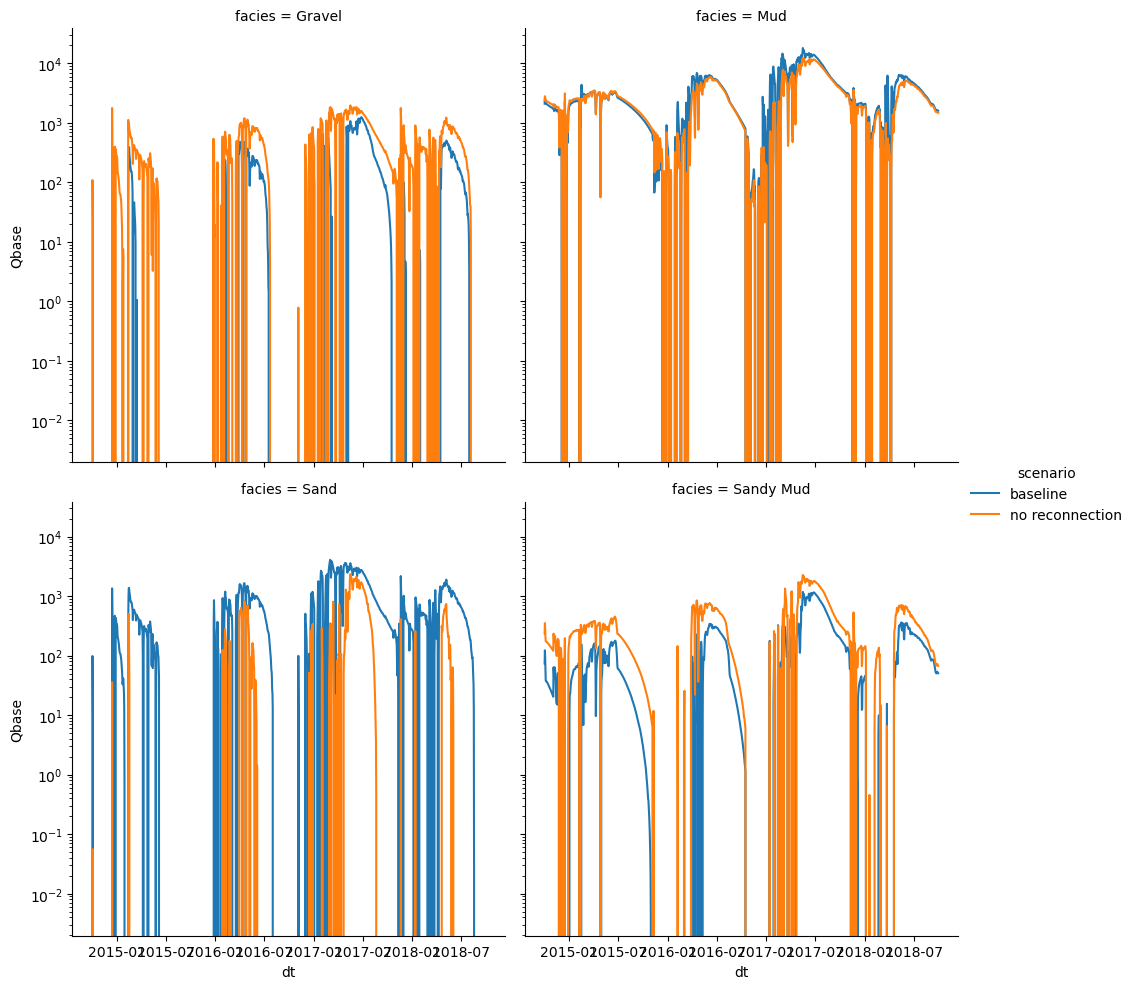

In [92]:
g = sns.relplot(facies_sum, 
            x='dt',y='Qbase', col='facies', hue='scenario', col_wrap=2, kind='line')
g.set(yscale='log')

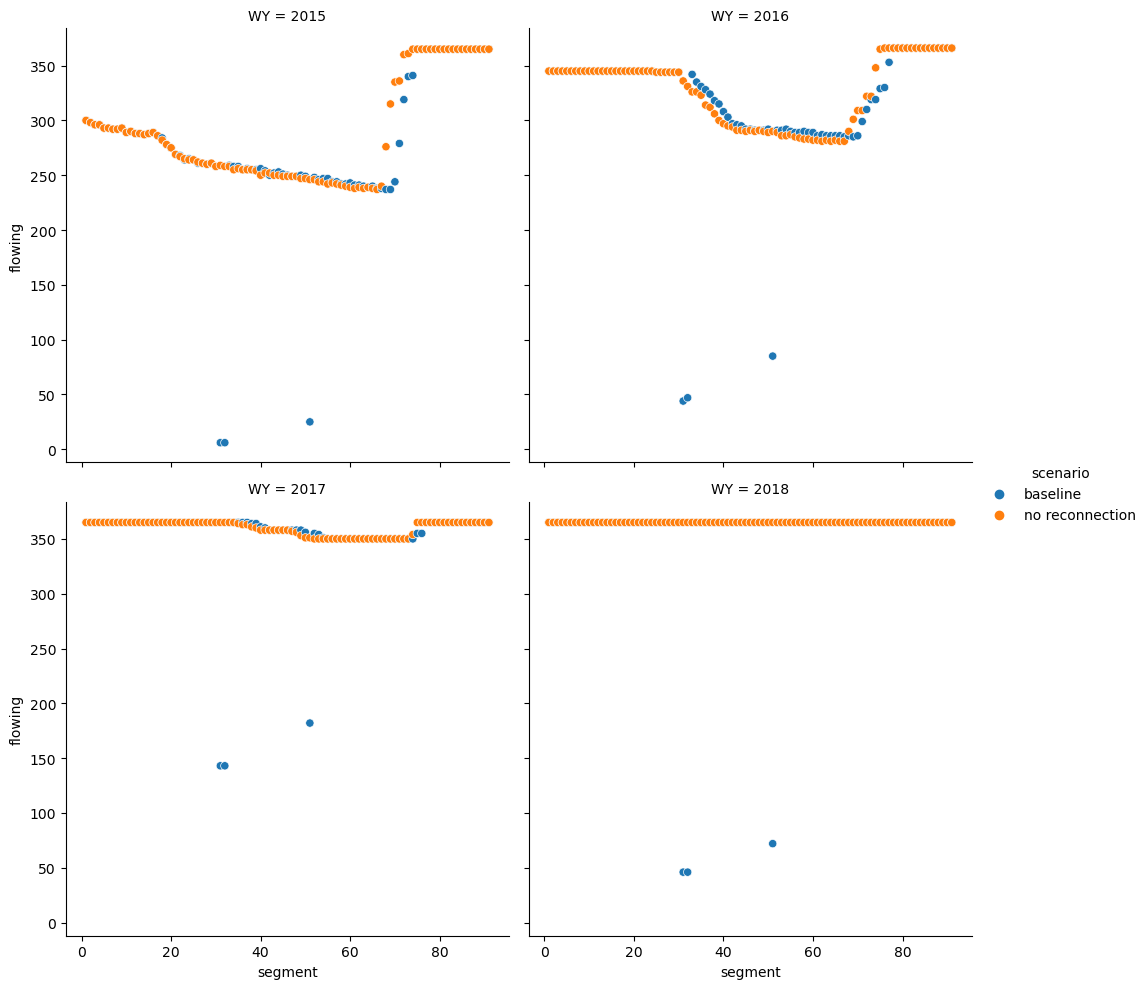

In [93]:
# find last day of flow

# start simple with just year by segment ,'month','facies'
sns.relplot(sfrdf_all.groupby(['WY','segment','scenario']).sum(numeric_only=True), x='segment',y='flowing', 
            col='WY', col_wrap=2, hue='scenario')

In [166]:
# grid_sfr[['iseg','ireach','facies']]
sfr_facies_sum = sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
seep_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)



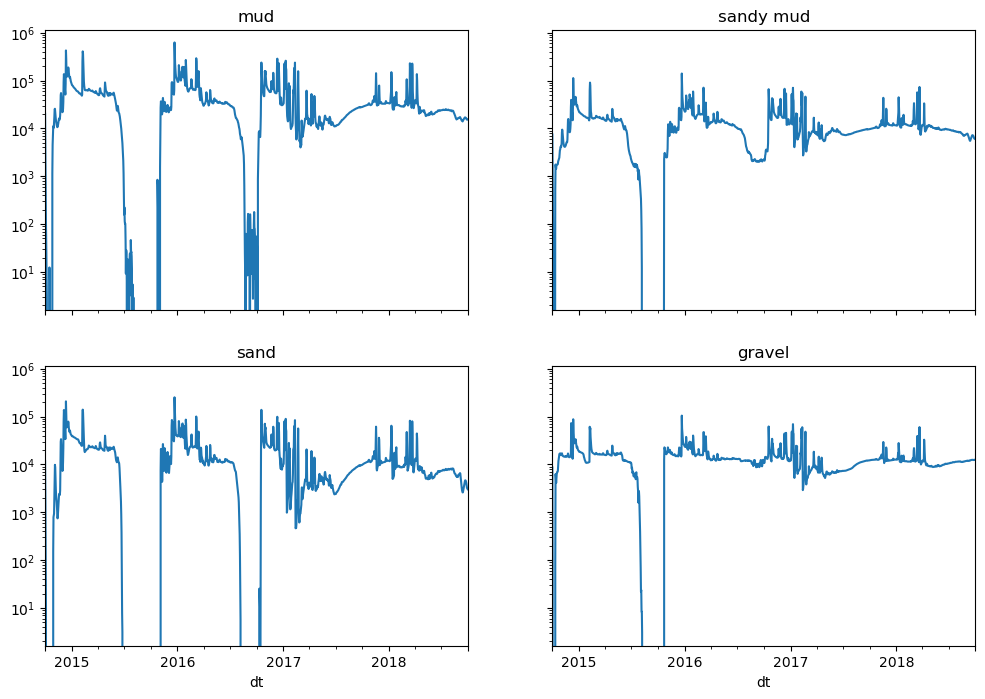

In [65]:
# som eissue with sharex is hiding mud probably issue of dt type, difference between mud and sandy mud
fig,ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)#

df_rech= seep_facies_sum[seep_facies_sum.variable=='Qrech'].reset_index('facies')
for n, f in enumerate(['mud','sandy mud','sand','gravel']):
    ax_n = ax[int(n/2), n%2]
    df_plt = df_rech[df_rech.facies==f]
    df_plt.index = pd.to_datetime(df_plt.index)
    df_plt.plot(y='value', ax=ax_n, legend=False)
    ax_n.set_title(f)
    ax_n.set_yscale('log')

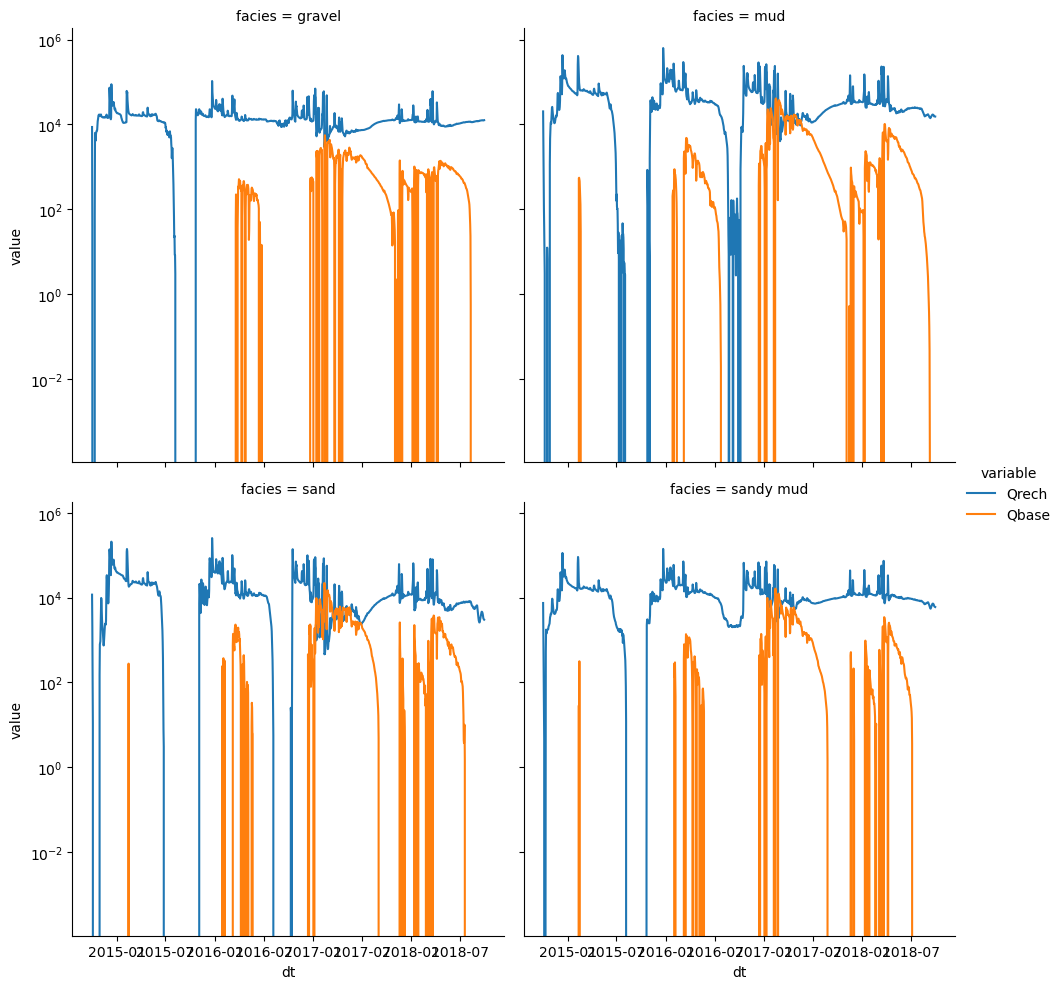

In [66]:
g = sns.relplot(sfr_facies_sum, x='dt',y='value',hue='variable', kind='line',
            col = 'facies', col_wrap=2)
g.set(yscale='log')

### Plot stream discretization

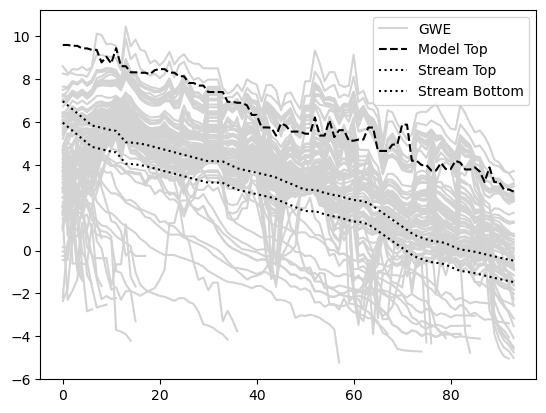

In [111]:

# spd_hd = dt_ref[dt_ref.dt == '2020-05-21'].kstpkper.values[0]
# head = hdobj.get_data(spd_hd)[0][0]

for t in spd_stp[0::90]: # every 7 days 
#     spd_hd = dt_ref[dt_ref.dt == t].kstpkper.values[0]
    head = hdobj.get_data(t)[grid_sfr.k, grid_sfr.i, grid_sfr.j]
    head = head[head!=-1e30]
    plt.plot(head, color='lightgray')
plt.plot(head,label = 'GWE',  color='lightgray')
plt.plot(m.dis.top.array[grid_sfr.i, grid_sfr.j], label='Model Top', ls='--',color='black')
plt.plot(m.sfr.reach_data.strtop, label= 'Stream Top', ls=':',color='black')
plt.plot(m.sfr.reach_data.strtop-m.sfr.reach_data.strthick, label= 'Stream Bottom', ls=':',color='black')

plt.legend()